In [ ]:
import torch
from torchvision import datasets, transforms

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

import os
try_data_dirs = ['/home/zhh/data','/home/zhh24/data']
for data_dir in try_data_dirs:
    if os.path.exists(data_dir):
        break
assert os.path.exists(data_dir), 'data_dir does not exist'

batch_size = 512
train_dataset = datasets.MNIST(root = data_dir,
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = data_dir,
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)

In [ ]:
class Avger(list):
    def __str__(self):
        return f'{sum(self) / len(self):.4f}' if len(self) > 0 else 'N/A'
    
from tqdm.notebook import tqdm,trange
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class BatchPrepareBase:
    def process(self, x):
        raise NotImplementedError

In [4]:
import os
import torchvision.utils as vutils
from tqdm import trange

class SamplerBase:
    def __init__(self):
        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)
        
    def calc(self, model, num):
        raise NotADirectoryError()
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [ ]:
class SanityVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        return x.cuda()
        
class NoiseVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        # noise = torch.randn_like(x)
        return ((x )/torch.sqrt(torch.tensor(2.))).cuda()
        

In [ ]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x_data = next(iter(test_loader))[0][:num].cuda()
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        # reconstruction
        
        mu, logvar = model.encode(x_data)
        x_recon = model.decode(mu+torch.randn_like(mu)*torch.exp(logvar/2))
        grid = vutils.make_grid(x_recon, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_recon.png')
        grid = vutils.make_grid(x_data, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_data.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [ ]:
from tqdm import tqdm
class VAE_trainer:
    def __init__(self, model, epochs,lr,desc,preparer:BatchPrepareBase,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            # opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger(); rec_loss = Avger(); kl_loss = Avger()
            
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs = self.preparer.process(x)
                    loss, rec, kl = self.model(inputs)
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item()); rec_loss.append(rec.item()); kl_loss.append(kl.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}, rec={rec_loss}, kl={kl_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [ ]:
from vae import noiseVAE
model = noiseVAE().cuda()
print('number of parameters:', sum(p.numel() for p in model.parameters()))
trainer = VAE_trainer(model, 50, 1e-3, 'sanity', NoiseVAE_BatchPrep(), VAE_Sampler())
trainer.run()

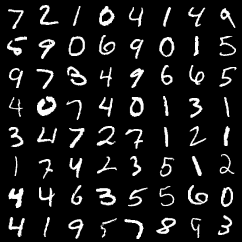

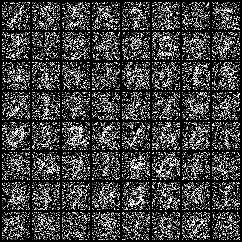

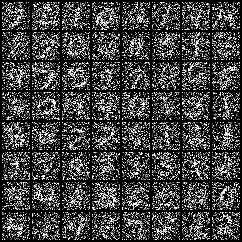

In [ ]:
display(Image('./samples/ep40_sanity_data.png'))
display(Image('./samples/ep40_sanity_gen.png'))
display(Image('./samples/ep40_sanity_recon.png'))